# **RL In-Class Exercise 1 Tutorial 2**
This notebook contains the in-class exercise 1 from tutorial 2 of Deep Reinforcement Learning in AML.

# Exercise Overview

In Tutorial 1, you implemented REINFORCE. Now you'll extend it to Actor-Critic!

## What changes from REINFORCE to Actor-Critic?

### Main differences:
1. **Two networks instead of one:** Actor (policy) + Critic (value function)
2. **Advantages instead of returns:** Use critic to estimate baselines
3. **Multiple critic updates:** Train critic more than actor
4. **New function: GAE** - Better advantage estimation

### Exercises:
**Exercise 1:** Modify `get_policy()` - Use actor network instead of policy_net

**Exercise 2:** Implement `compute_gae()` - Generalized Advantage Estimation

**Exercise 3:** Modify `compute_loss()` → `get_actor_loss()` (mostly renaming)

**Exercise 4:** Modify `train_one_epoch()` - Collect next_obs, use GAE, train critic

**Exercise 5:** Modify the training cell - Create actor & critic networks

# Install & Import Requirements



In [1]:
!pip install swig
!pip install gymnasium[box2d]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.optim import Adam
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Sequence
from tqdm import tqdm

/home/lamberto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Helper functions

## MLP function to create the policy network of our agent

In [3]:
def mlp(sizes: Sequence[int], activation=nn.ReLU, output_activation=nn.Identity) -> nn.Sequential:
  """
  Create a simple feedforward neural network.
  """
  layers = []
  for j in range(len(sizes)-1):
    act = activation if j < len(sizes)-2 else output_activation
    layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
  return nn.Sequential(*layers)

## EXERCISE 1: Modify functions to get the output of the policy network

In Actor-Critic, the policy network is called 'actor' instead of 'policy_net'.

Modification needed:
- Change 'policy_net' to 'actor' (one word change!)

In [4]:
def get_policy(obs: torch.Tensor) -> Normal:
  """
  Get the stochastic policy for a given observation (-batch).
  Returns a distribution for every action.
  """
  obs = obs.unsqueeze(0) if obs.dim() == 1 else obs  # for single observations that do not have a batch dimension
  logits = actor(obs)
  mean, logstd = logits[:, :n_acts], logits[:, n_acts:]  # split the output layer into mean and logstd
  logstd = torch.clamp(logstd, min=-20, max=2)  # for numerical stability
  return Normal(mean, torch.exp(logstd))

In [5]:
def get_action(obs: torch.Tensor) -> np.ndarray:
  """
  Get the action for a given observation.
  """
  dist = get_policy(obs)
  return dist.sample().squeeze(0).numpy()

## EXERCISE 2: Implement compute_gae

In [6]:
def compute_gae(rewards: torch.Tensor,
                values: torch.Tensor,
                next_values: torch.Tensor,
                dones: torch.Tensor,  # values are either 1.0 (has ended) or 0.0 (has not ended), indicating whether an episode has ended or not.
                gamma=0.99,  # discount factor (0,1]
                lam=0.95,  # trace-decay parameter [0,1]. lam=0.0: temporal difference, lam=1.0: Monte Carlo
                ) -> torch.Tensor:
    """
    Compute the Generalized Advantage Estimation (GAE) used for the actor loss function.
    Balances the bias-variance tradeoff of the advantage estimates.
    lam=0.0: temporal difference, high bias - low variance
    lam=1.0: Monte Carlo, high variance - low bias

    Args:
        rewards: Rewards for each timestep, shape (T,)
        values: Value estimates V(s_t) for each timestep, shape (T,)
        next_values: Value estimates V(s_{t+1}) for each timestep, shape (T,)
        dones: Done flags (1.0 if episode ended, 0.0 otherwise), shape (T,)
        gamma: Discount factor (0, 1]
        lam: GAE lambda parameter [0, 1] for bias-variance tradeoff

    Returns:
        advantages: GAE advantages for each timestep, shape (T,)

    Hint: Loop backwards through time (use reversed(range(T)))
    Hint: Remember to multiply by (1 - done) to handle episode boundaries
    """
    T = rewards.shape[0]
    advantages = torch.zeros_like(rewards)
    gae = 0
    for t in reversed(range(T)):
        nonterminal = 1.0 - dones[t]
        # NOTE: temporal difference
        delta = rewards[t] + gamma * next_values[t] * nonterminal - values[t] # NOTE: nonterminal is used to kill t+1 if episode finished
        gae = delta + gamma * lam * nonterminal * gae
        advantages[t] = gae
    return advantages

### Test Functions (Feel free to collapse this cell)

In [7]:
def test_compute_gae(compute_gae_fn):
    """
    Test the compute_gae implementation.
    """
    results = []

    # Test 1: Output shape matches input shape
    try:
        T = 10
        rewards = torch.randn(T)
        values = torch.randn(T)
        next_values = torch.randn(T)
        dones = torch.zeros(T)

        advantages = compute_gae_fn(rewards, values, next_values, dones)

        if advantages.shape == torch.Size([T]):
            print("✓ Test 1: Output shape correct")
            results.append(True)
        else:
            print(f"✗ Test 1: Output shape should be ({T},)")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 1: Error - {type(e).__name__}")
        results.append(False)

    # Test 2: Output dtype is correct
    try:
        T = 10
        rewards = torch.randn(T)
        values = torch.randn(T)
        next_values = torch.randn(T)
        dones = torch.zeros(T)

        advantages = compute_gae_fn(rewards, values, next_values, dones)

        if advantages.dtype == torch.float32:
            print("✓ Test 2: Output dtype correct")
            results.append(True)
        else:
            print(f"✗ Test 2: Output dtype should be float32")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 2: Error - {type(e).__name__}")
        results.append(False)

    # Test 3: Different lambda values produce different results
    try:
        torch.manual_seed(42)
        T = 10
        rewards = torch.randn(T)
        values = torch.randn(T)
        next_values = torch.randn(T)
        dones = torch.zeros(T)

        adv_lam0 = compute_gae_fn(rewards, values, next_values, dones, gamma=0.99, lam=0.0)
        adv_lam1 = compute_gae_fn(rewards, values, next_values, dones, gamma=0.99, lam=1.0)

        if not torch.allclose(adv_lam0, adv_lam1):
            print("✓ Test 3: Different lambda values produce different advantages")
            results.append(True)
        else:
            print("✗ Test 3: Different lambda values should produce different results")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 3: Error - {type(e).__name__}")
        results.append(False)

    # Test 4: Done flags affect computation
    try:
        torch.manual_seed(42)
        T = 10
        rewards = torch.randn(T)
        values = torch.randn(T)
        next_values = torch.randn(T)
        dones_zero = torch.zeros(T)
        dones_one = torch.ones(T)

        adv_no_done = compute_gae_fn(rewards, values, next_values, dones_zero)
        adv_all_done = compute_gae_fn(rewards, values, next_values, dones_one)

        if not torch.allclose(adv_no_done, adv_all_done):
            print("✓ Test 4: Done flags affect advantages")
            results.append(True)
        else:
            print("✗ Test 4: Done flags should affect advantages")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 4: Error - {type(e).__name__}")
        results.append(False)

    # Test 5: Works with different trajectory lengths
    try:
        for T in [5, 10, 50, 100]:
            rewards = torch.randn(T)
            values = torch.randn(T)
            next_values = torch.randn(T)
            dones = torch.zeros(T)

            advantages = compute_gae_fn(rewards, values, next_values, dones)

            if advantages.shape != torch.Size([T]):
                print(f"✗ Test 5: Failed for trajectory length {T}")
                results.append(False)
                break
        else:
            print("✓ Test 5: Works with different trajectory lengths")
            results.append(True)
    except Exception as e:
        print(f"✗ Test 5: Error - {type(e).__name__}")
        results.append(False)

    return sum(results), len(results)

### Run Tests

In [8]:
passed, total = test_compute_gae(compute_gae)
print(f"\n{'='*50}")
print(f"Results: {passed}/{total} tests passed")
if passed == total:
  print("🎉 All tests passed! You're ready to move on.")
else:
  print("⚠️  Some tests failed. Review your implementation.")

✓ Test 1: Output shape correct
✓ Test 2: Output dtype correct
✓ Test 3: Different lambda values produce different advantages
✓ Test 4: Done flags affect advantages
✓ Test 5: Works with different trajectory lengths

Results: 5/5 tests passed
🎉 All tests passed! You're ready to move on.


## EXERCISE 3: Modify compute_loss → get_actor_loss

In Actor-Critic, we rename compute_loss to get_actor_loss for clarity.
The logic stays the same.

Modifications needed:
1. Rename the function from compute_loss to get_actor_loss
2. The implementation stays exactly the same!

In [9]:
def get_actor_loss(obs: torch.Tensor, act: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
  """
  Compute the loss function for the actor.
  weights: advantages, can be A_GAE but also A_TD (lam=0)
  """
  dist = get_policy(obs)
  logp = dist.log_prob(act).sum(dim=-1)
  return -(logp * weights).mean()

## Function to compute the discounted return

In [10]:
def discounted_return(arr: Sequence[float], gamma: float = 0.99) -> list[float]:
  """
  Compute the discounted return for a single episode, given a sequence of rewards.
  """
  ret = [0.0] * len(arr)
  ret[-1] = arr[-1]
  for i in range(len(arr)-2, -1, -1):
    ret[i] = arr[i] + gamma * ret[i+1]
  return ret

## EXERCISE 4: Modify train_one_epoch

This is where the major changes happen for Actor-Critic!

Key changes:
1. Collect next_obs and dones during rollout
2. Still compute batch_Rtogo for critic targets
3. Use critic network to compute values
4. Use compute_gae() for advantage estimation
5. Multiple critic updates (not just one)
6. Single actor update

In [15]:
def train_one_epoch() -> tuple[list, list]:
  """
  Train the policy for one epoch i.e. one update.
  """
  batch_obs = []
  batch_acts = []
  # TODO: Remove batch_weights - we'll use advantages from GAE
  # batch_weights = []
  batch_rets = []
  batch_lens = []
  # TODO: Add buffer for:
  # - next observations
  # - dones (will store 1's if the episode ended in this steps, else 0's)
  # - Rtogo
  # - individual rewards
  batch_rewards = []
  batch_next_obs = []
  batch_dones = []
  batch_rtogo = []

  obs, _ = env.reset()
  ep_rews = []
  while True:
    act = get_action(torch.as_tensor(obs, dtype=torch.float32))
    next_obs, rew, terminated, truncated, _ = env.step(act)  # the environment will automatically clip the action to [-1,1]

    batch_obs.append(obs.copy())  # copy as obs is modified in-place
    batch_acts.append(act)  # act is newly initialized every loop -> no copy
    ep_rews.append(rew)
    # TODO: add data to your new buffers
    batch_rewards.append(rew)
    batch_next_obs.append(next_obs.copy())

    obs = next_obs
    done = terminated or truncated
    batch_dones.append(done)

    if done:
      ep_ret, ep_len = sum(ep_rews), len(ep_rews)
      batch_rets.append(ep_ret)
      batch_lens.append(ep_len)

      # TODO: Change this to calculate and update Rtogo
      batch_rtogo += discounted_return(ep_rews,gamma=gamma)

      obs, _ = env.reset()
      ep_rews = []

      if len(batch_obs) > batch_size:
        break

  # convert lists to tensors
  batch_obs = torch.as_tensor(np.array(batch_obs), dtype=torch.float32)
  batch_acts = torch.as_tensor(np.array(batch_acts), dtype=torch.float32)
  # TODO: Remove batch_weights and convert the rest of the buffer to torch tensors
  batch_next_obs = torch.as_tensor(np.array(batch_next_obs), dtype=torch.float32)
  batch_rewards = torch.as_tensor(np.array(batch_rewards), dtype=torch.float32)
  batch_dones = torch.as_tensor(np.array(batch_dones), dtype=torch.float32)
  batch_rtogo = torch.as_tensor(np.array(batch_rtogo), dtype=torch.float32)
  # TODO: Calculate target values for critic training
  V_target = batch_rtogo.detach() 
  # TODO: Udate Critic (multiple with new hyperparameter)
  for _ in range(n_critic_updates):
    critic_optimizer.zero_grad()
    critic_loss = mse(critic(batch_obs).squeeze(), V_target)
    critic_loss.backward()
    critic_optimizer.step()

  # TODO: Compute advantage estimate GAE
  # TODO: Use torch.no_grad() context since advantages shouldn't have gradients
  # TODO: Inside no_grad: Compute needed values for GAE and compute GAE
  with torch.no_grad():
    value = critic(batch_obs).squeeze()
    next_values = critic(batch_next_obs).squeeze()
    A_gae = compute_gae(batch_rewards, value, next_values, batch_dones,gamma=gamma, lam=lam)

  # TODO: Normalize advantages
  A_gae = ((A_gae - A_gae.mean()) / (A_gae.std() + 1e-8))

  # TODO: Adjust to update Actor (single update)
  actor_optimizer.zero_grad()
  actor_loss = get_actor_loss(batch_obs, batch_acts, A_gae)
  actor_loss.backward()
  actor_optimizer.step()

  return batch_rets, batch_lens

# EXERCISE 5: Modify the training cell


Final exercise! Set up the Actor-Critic training.

Changes needed:
1. Add new hyperparameters (lr_critic, n_critic_updates, lam)
2. Create TWO networks: actor and critic (not just policy_net)
3. Create TWO optimizers: actor_optimizer and critic_optimizer
4. Create MSE loss for critic
5. Everything else stays the same!

100%|██████████| 10/10 [00:19<00:00,  1.93s/it, avg_ret=-243, avg_len=113]


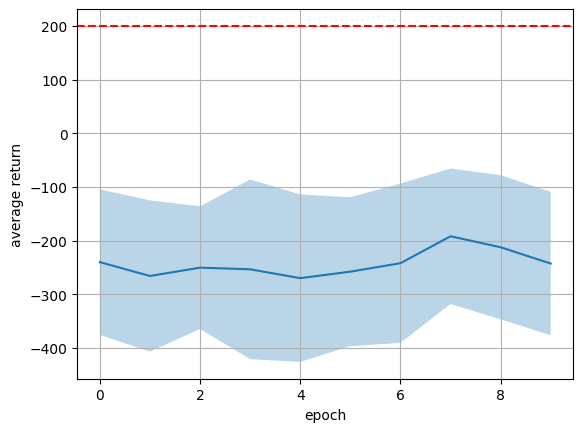

In [16]:

env_name="LunarLander-v3"
hidden_sizes=[64,64]
lr=3e-4
epochs=10
batch_size=5_000
gamma=0.99
plot = True
# TODO: Add hyperparameters
lr_critic = 1e-3
n_critic_updates = 80
lam = 0.95

env = gym.make(env_name, continuous=True) if env_name == "LunarLander-v3" else gym.make(env_name)  # BipedalWalker is continuous per default

obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.shape[0]

# TODO: Adjust to create a actor and critic net an initialize their optimizers
actor = mlp([obs_dim]+hidden_sizes+[2*n_acts])
critic =mlp([obs_dim]+hidden_sizes+[1])
actor_optimizer = Adam(actor.parameters(), lr=lr)
critic_optimizer = Adam(critic.parameters(), lr=lr_critic)


# TODO: Create MSE loss for critic training
mse= nn.MSELoss()

returns = []
std = []

# training loop
progress_bar = tqdm(range(1, epochs+1))
for _ in progress_bar:
  batch_rets, batch_lens = train_one_epoch()
  avg_ret = np.mean(batch_rets)
  avg_len = np.mean(batch_lens)
  returns.append(avg_ret)
  std.append(np.std(batch_rets))
  progress_bar.set_postfix({"avg_ret": f"{avg_ret:5.0f}", "avg_len": f"{avg_len:5.0f}"})

if plot:
  plt.plot(returns)
  plt.fill_between(range(len(returns)), np.array(returns) - np.array(std), np.minimum(300, np.array(returns) + np.array(std)), alpha=0.3)
  plt.grid()
  goal = {"LunarLander-v3": 200, "BipedalWalker-v3": 300}.get(env_name, 0)
  plt.axhline(goal, color='r', linestyle='--')
  plt.xlabel('epoch')
  plt.ylabel('average return')
  timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  # TODO: Change filename
  plt.savefig(f"Actor-Critic_training_{timestamp}.png")
  plt.show()